In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import timm

In [2]:
train_df = pd.read_csv('./image_label')

In [3]:
train_df.head()

,Unnamed: 0,path,label
0,0,../input/data/train/images/000001_female_Asian...,10
1,1,../input/data/train/images/000001_female_Asian...,4
2,2,../input/data/train/images/000001_female_Asian...,4
3,3,../input/data/train/images/000001_female_Asian...,4
4,4,../input/data/train/images/000001_female_Asian...,4


In [4]:
np.sort(train_df['label'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

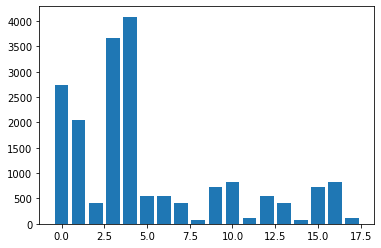

In [5]:
plt.bar(np.sort(train_df['label'].unique()), train_df['label'].value_counts().sort_index())
plt.show()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda': torch.cuda.manual_seed_all(1)

In [7]:
class TrainSet(Dataset):
    def __init__(self, train_image, train_label, transform):
        self.train_image = train_image.tolist()
        self.train_label = train_label.tolist()
        self.transform = transform
    def __len__(self):
        return len(self.train_label)
    def __getitem__(self, index):
        image = Image.open(self.train_image[index])
        label = torch.tensor(self.train_label[index])
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# mask, not 60 -> label: 0, 1, 3, 4
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
splits = KFold(n_splits=5, shuffle=False)
fold_dict = {}

In [10]:
def train_epoch(model, device, dataloader, criterion, optimizer):
    train_loss, train_correct = 0, 0
    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()                                 # optimizer의 모든 파라미터들의 grad를 초기화한다.
        hypothesis = model(images)                            # images를 model에 넣어주고 예측한다.
        loss = criterion(hypothesis, labels)                    # loss값을 구한다.
        loss.backward()                                       # loss값에 대해 미분을 수행한다.
        optimizer.step()                                      # 학습을 진행한다. (optimizer를 한 단계 수행한다.)
        train_loss += loss.item() * images.size(0)            # loss값에 image의 개수를 곱하고 저장한다.
        scores, predictions = torch.max(hypothesis.data, 1)   # max로 가장 높게 예측한 값의 인덱스와 값(정수)를 뽑아준다.
        train_correct += (predictions == labels).sum().item() # 인덱스가 label과 맞는지 확인하고 합을 구해서 맞힌 개수를 저장한다.
  
    return train_loss, train_correct

In [11]:
def valid_epoch(model, device, dataloader, criterion):
  valid_loss, val_correct = 0.0, 0
  model.eval()
  for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      prediction = model(images)
      loss=criterion(prediction,labels)
      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(prediction.data,1)
      val_correct+=(predictions == labels).sum().item()

  return valid_loss,val_correct

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', model_name = None, fold=None):
        self.fold = fold
        self.model_name = model_name
        
        self.patience = patience                    # 학습이 개선되지 않을 경우 참을 횟수
        self.verbose = verbose                      # 학습 개선 메세지를 출력할지 여부 결정
        self.counter = 0                            # 학습이 개선되지 않은 횟수
        self.best_score = None                      # 지금까지 가장 최적의 loss
        self.early_stop = False                     # early_stop을 해야하는 경우 True로 값 변경
        self.val_loss_min = np.Inf                  
        self.delta = delta                          # 최소한의 loss값 개선 수준
        self.path = path                            # 모델을 저장할 주소
        
    def __call__(self, val_loss, model):
        score = -val_loss                           # loss값을 음수로 바꾼다.

        if self.best_score is None:                 # best_score에 score가 저장된 적이 없다면 
            self.best_score = score                 # 해당값을 best_score에 저장하고
            self.save_checkpoint(val_loss, model)   # loss값과 model을 저장한다.
        elif score < self.best_score + self.delta:  # best_score에 delta를 더한 값보다 score가 작다면 == 이전 최대 점수에 delta를 뺀 값보다 score가 크다면 (delta값은 어느 정도의 학습을 강제하는 느낌인 것 같다.)
            self.counter += 1                       # counter값을 갱신하고
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:       # counter값이 patience보다 크다면
                self.early_stop = True              # early_stop을 True로 갱신한다.
        else:
            self.best_score = score                 # 만약 loss값이 알맞게 감소했다면
            self.save_checkpoint(val_loss, model)   # loss값과 model을 저장한다.
            self.counter = 0                        # counter값도 다시 0으로 초기화한다.

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.fold is not None and self.model_name is not None:
            torch.save(model.state_dict(), self.model_name + '_'+ str(self.fold)+'fold_'+self.path)
        else:
            torch.save(model.state_dict(),self.path)
        self.val_loss_min = val_loss

In [13]:
train_dataset = TrainSet(train_df['path'], train_df['label'], transform)
criterion = nn.CrossEntropyLoss()
batch_size = 128
num_epochs = 30

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):
    print('Fold {}'.format(fold + 1))
    early_stopping = EarlyStopping(patience=5, verbose=False, fold=fold, model_name = 'ResNet18_noShuffle')
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        valid_loss, val_correct=valid_epoch(model,device,valid_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        valid_loss = valid_loss / len(valid_loader.sampler)
        valid_acc = val_correct / len(valid_loader.sampler) * 100

        print(f"[Epoch:{epoch+1}/{num_epochs}] AVG Training Loss/Acc: {train_loss:.3f}/{train_acc:.2f}, AVG Test Loss/Acc: {valid_loss:.3f}/{valid_acc:.2f}")
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    fold_dict['fold{}'.format(fold+1)] = history

Fold 1
[Epoch:1/30] AVG Training Loss/Acc: 0.427/85.79, AVG Test Loss/Acc: 1.197/70.03
[Epoch:2/30] AVG Training Loss/Acc: 0.157/94.42, AVG Test Loss/Acc: 1.907/54.60
EarlyStopping counter: 1 out of 5
[Epoch:3/30] AVG Training Loss/Acc: 0.138/95.15, AVG Test Loss/Acc: 1.207/73.73
EarlyStopping counter: 2 out of 5
[Epoch:4/30] AVG Training Loss/Acc: 0.063/97.99, AVG Test Loss/Acc: 1.100/78.12
[Epoch:5/30] AVG Training Loss/Acc: 0.032/99.11, AVG Test Loss/Acc: 0.827/77.96
[Epoch:6/30] AVG Training Loss/Acc: 0.018/99.40, AVG Test Loss/Acc: 1.093/79.13
EarlyStopping counter: 1 out of 5
[Epoch:7/30] AVG Training Loss/Acc: 0.025/99.19, AVG Test Loss/Acc: 1.286/74.76
EarlyStopping counter: 2 out of 5
[Epoch:8/30] AVG Training Loss/Acc: 0.047/98.47, AVG Test Loss/Acc: 1.101/79.10
EarlyStopping counter: 3 out of 5
[Epoch:9/30] AVG Training Loss/Acc: 0.040/98.65, AVG Test Loss/Acc: 1.181/76.08
EarlyStopping counter: 4 out of 5
[Epoch:10/30] AVG Training Loss/Acc: 0.066/97.78, AVG Test Loss/Acc: 

In [15]:
import os
test_dir = '/opt/ml/input/data/eval'
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

dataset = TestDataset(image_paths, transform_test)

loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model1 = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device); model1.load_state_dict(torch.load('./ResNet_noShuffle_noAug/0fold_checkpoint.pt'))
model2 = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device); model2.load_state_dict(torch.load('./ResNet_noShuffle_noAug/1fold_checkpoint.pt'))
model3 = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device); model3.load_state_dict(torch.load('./ResNet_noShuffle_noAug/2fold_checkpoint.pt'))
model4 = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device); model4.load_state_dict(torch.load('./ResNet_noShuffle_noAug/3fold_checkpoint.pt'))
model5 = timm.create_model('resnet18', pretrained=True, num_classes=18).to(device); model5.load_state_dict(torch.load('./ResNet_noShuffle_noAug/4fold_checkpoint.pt'))
models = [model1, model2, model3, model4, model5]

for model in models:
    model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        pred = 0
        images = images.to(device)
        for model in models:
            pred += model(images) / len(models) 
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
